## Step 1: Import necessary libraries

In [1]:

# Packages needed generally
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
import xarray as xr
import pandas as pd
import numpy as np
from rasterio import mask

# Packages needed for CESM1 example
import pprint
import intake
import requests
import aiohttp
import s3fs

# Packages needed for CMIP6
import zarr
import gcsfs

## Step 2: Data access

In [2]:
# Open original collection description file: CESM1 LENS
cat_url = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json"
col = intake.open_esm_datastore(cat_url)
col

# Location of file containing grid (lat/lon) information for CESM1 LENS
grid_url="s3://ncar-cesm-lens/ocn/static/grid.zarr"

## Step 3: Subset data to regoin of interest

In [9]:
# Search for the sea surface variable, display the first few entries in the resulting data frame
col.search(variable="TEMP").df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,CTRL,monthly,60.0,global_ocean,degC,0400-01-16 12:00:00,2200-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-CTRL-TE...
2,TEMP,potential temperature,ocn,HIST,monthly,60.0,global_ocean,degC,1850-01-16 12:00:00,1919-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-HIST-TE...
3,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [10]:
# Get more detailed: search for monthly output for the 20th century and RCP8.5 
# ("HIST" is the 1850-1919 period, which is only in the first ensemble member, and "20C" is 1920-2005 which is common across all the other members)
col_ocntemp = col.search(
    frequency=["monthly"],
    component="ocn",
    variable="TEMP",
    experiment=["20C", "RCP85"],  
)

col_ocntemp.df

,variable,long_name,component,experiment,frequency,vertical_levels,spatial_domain,units,start_time,end_time,path
0,TEMP,potential temperature,ocn,20C,monthly,60.0,global_ocean,degC,1920-01-16 12:00:00,2005-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-20C-TEM...
1,TEMP,potential temperature,ocn,RCP85,monthly,60.0,global_ocean,degC,2006-01-16 12:00:00,2100-12-16 12:00:00,s3://ncar-cesm-lens/ocn/monthly/cesmLE-RCP85-T...


In [11]:
# Load catalog entries for subset into a dictionary of xarray datasets
dsets = col_ocntemp.to_dataset_dict(
    zarr_kwargs={"consolidated": True}, storage_options={"anon": True}
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'



Dataset dictionary keys:
 dict_keys(['ocn.20C.monthly', 'ocn.RCP85.monthly'])


In [12]:
# Get file containing lat/lon grid information: s3://ncar-cesm-lens/ocn/static/grid.zarr
fs = s3fs.S3FileSystem(anon=True)
grid = xr.open_zarr(fs.get_mapper(grid_url), consolidated=True) #we need to mess with this to get coordinates for channel islands
#grid.z_t.plot.scatter() #for vertical profile
grid

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_w: 60,
                           lat_aux_grid: 395, moc_comp: 3, moc_z: 61,
                           transport_comp: 5, transport_reg: 2, z_t_150m: 15,
                           z_w_bot: 60, z_w_top: 60)
Coordinates: (12/63)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(192, 160), meta=np.ndarray>
    ...                    ...
    vonkar                float64 ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
Dimensions without coordinates: nlat, nlon, moc_comp, transport_comp,
                                transport_reg
Data variables:
    *empty*

In [13]:
# Define Xarray datasets corresponding to the three experiments
ds_20C = dsets["ocn.20C.monthly"]
ds_RCP85 = dsets["ocn.RCP85.monthly"]

#look at ds_20C dataset
ds_20C

<xarray.Dataset>
Dimensions:     (member_id: 40, time: 1032, z_t: 60, nlat: 384, nlon: 320, d2: 2)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
  * time        (time) object 1920-01-16 12:00:00 ... 2005-12-16 12:00:00
    time_bound  (time, d2) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    TEMP        (member_id, time, z_t, nlat, nlon) float32 dask.array<chunksize=(1, 6, 60, 384, 320), meta=np.ndarray>
Attributes: (12/24)
    Conventions:                       CF-1.0; http://www.cgd.ucar.edu/cms/ea...
    calendar:                          All years have exactly  365 days.
    cell_methods:                      cell_methods = time: mean ==> the vari...
    contents:                          Diagnostic and Prognostic Variables
    nco_openmp_thread_number:          1
    nsteps_total:                      750
    ...                                ...
    intake_esm_attrs:units:            degC
    intake_esm_attrs:start_time:       1920-01-16 12:00:00
    intake_esm_attrs:end_time:         2005-12-16 12:00:00
    intake_esm_attrs:path:             s3://ncar-cesm-lens/ocn/monthly/cesmLE...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            ocn.20C.monthly

## Vertical Profile

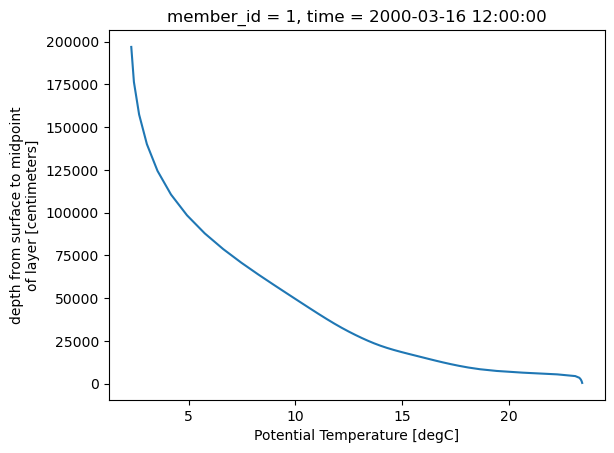

In [20]:
slice_time = ds_20C.sel(time = "2000-03")

slice_time

temp_2000 = slice_time.TEMP.sel(member_id = 1)

temp_2000

temp_2000_03 = temp_2000.isel(nlat = 90, nlon = 75)

temp_2000_03.plot(y = 'z_t')